## Store Sales - Time Series Forecasting

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.encoding import CountFrequencyEncoder

# Metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 1st Part: **EDA**

In [2]:
# Paths
train_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\train.csv"
test_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\test.csv"
stores_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\stores.csv"
oil_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\oil.csv"
transactions_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\transactions.csv"
holidays_events_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\holidays_events.csv"

<p style="text-align: justify"> When we see to this dataset, we see that columns dates are deconfigured. One option to solve this is to focus the feature values ​​around the day of the date column. Let's see how we can do this.</p>

In [3]:
# Importing Datasets
train = pd.read_csv(train_pth)
test = pd.read_csv(test_pth)
stores = pd.read_csv(stores_pth)
oil = pd.read_csv(oil_pth)
events = pd.read_csv(holidays_events_pth, parse_dates=['date'])
transactions = pd.read_csv(transactions_pth)

In [4]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
df = pd.merge(train,stores, on='store_nbr')
df['date'] = pd.to_datetime(df['date'])

transactions_store = transactions.groupby('store_nbr')['transactions'].sum()
transactions_date = transactions.groupby('date')['transactions'].sum()

# Merge df with events
events.reset_index(inplace=True)
events['date'] = pd.to_datetime(events['date'])
df = pd.merge(df, events, on = 'date', how='outer')

# Merge df with oil
oil['date'] = pd.to_datetime(oil['date'])
df = pd.merge(df, oil, on = 'date',how='outer')

# Merge df with Transaction_store and Transactions_date
df = pd.merge(df, transactions_store, on='store_nbr',how = 'outer')
transactions_date = pd.DataFrame(transactions_date).reset_index()
transactions_date['date'] = pd.to_datetime(transactions_date['date'])
df = pd.merge(df, transactions_date, on='date', how='outer')

df.dropna(subset='id', inplace=True)

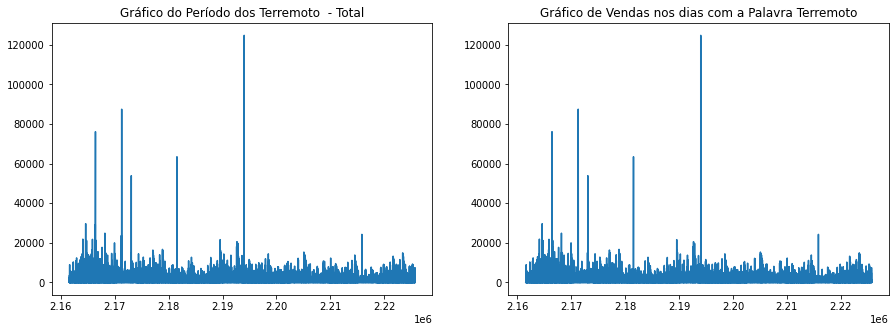

Total de Vendas no Período de Terremotos (TOTAL): 32,106,103.000000
Total de Vendas no Período de Terremotos : 27,339,491.000000


In [7]:
df_terremoto = df[df['description'].str.contains('Terremoto', na = False)]
max = df_terremoto['date'].max()
min = df_terremoto['date'].min()

selecao = (df['date'] >= min) & (df['date'] <= max)
df_filte = df[selecao]

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(df_filte['sales'])
ax[0].set_title('Gráfico do Período dos Terremoto  - Total')
ax[1].plot(df_terremoto['sales'])
ax[1].set_title('Gráfico de Vendas nos dias com a Palavra Terremoto')
plt.show()
soma_fil = round(df_filte['sales'].sum(),0)
print(f"Total de Vendas no Período de Terremotos (TOTAL): {soma_fil:2,f}")

soma_terr = round(df_terremoto['sales'].sum(),0)
print(f"Total de Vendas no Período de Terremotos : {soma_terr:2,f}")

# Impactou muito!!!

In [8]:
df_cat_col = [c for c in df.columns if df[c].dtypes=='O'] # Separating Categoricals Columns
df.fillna(0, inplace=True)
df = CountFrequencyEncoder(variables=df_cat_col).fit_transform(df)


In [9]:
# Total Lines
lines = df.shape[0]
print(f'DataFrame has {lines:1,d} lines.')

# Separating Features and Target
X = df.drop(labels=['sales'], axis=1)
y = df['sales']

# Train - Test values
train_values = int(lines * 0.7)

X_train = X[:train_values]
y_train = X[train_values:]

X_test = y[:train_values]
y_test = y[train_values:]

DataFrame has 3,054,348 lines.


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((X_train.drop('date', axis=1).values, X_test.values))

In [11]:
train_dataset = dataset.shuffle(len(df)).batch(1000)

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = get_compiled_model()

model.fit(train_dataset, epochs=15)

Epoch 1/15
2139/2139 [==============================] - 12s 4ms/step - loss: 1015791936.0000 - mae: 16751.7480 - mse: 1015791936.0000
Epoch 2/15
2139/2139 [==============================] - 11s 4ms/step - loss: 1006539.6875 - mae: 402.5288 - mse: 1006539.6875
Epoch 3/15
2139/2139 [==============================] - 11s 4ms/step - loss: 952553.9375 - mae: 405.6093 - mse: 952553.9375
Epoch 4/15
2139/2139 [==============================] - 11s 4ms/step - loss: 968550.2500 - mae: 411.6862 - mse: 968550.2500
Epoch 5/15
2139/2139 [==============================] - 11s 4ms/step - loss: 986737.5000 - mae: 432.2040 - mse: 986737.5000
Epoch 6/15
2139/2139 [==============================] - 11s 4ms/step - loss: 978919.2500 - mae: 448.5675 - mse: 978919.2500
Epoch 7/15
2139/2139 [==============================] - 11s 4ms/step - loss: 1303147.5000 - mae: 464.0604 - mse: 1303147.5000
Epoch 8/15
2139/2139 [==============================] - 11s 4ms/step - loss: 1281318.5000 - mae: 464.1364 - mse: 12813